In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import savgol_filter
%matplotlib inline

In [24]:
disp_figs = True

In [65]:
M = 4 # Number of Spiking motifs
N = 20 # Number of input neurons
D = 71 # temporal depth of receptive field
T = 1000
nrn_fr = 20 # hz
pg_fr = 3 # hz

np.random.seed(41)

In [51]:
# for matplotlib
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
len(colors)

10

# Generate the PG Kernels


In [41]:
# I will try and do this with dense and sparse representations at the same time
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.randint(0,T-1,(N,D,M))
K_dense[K_dense < nrn_fr] = 1
K_dense[K_dense >= nrn_fr] = 0
K_sparse = np.where(K_dense)

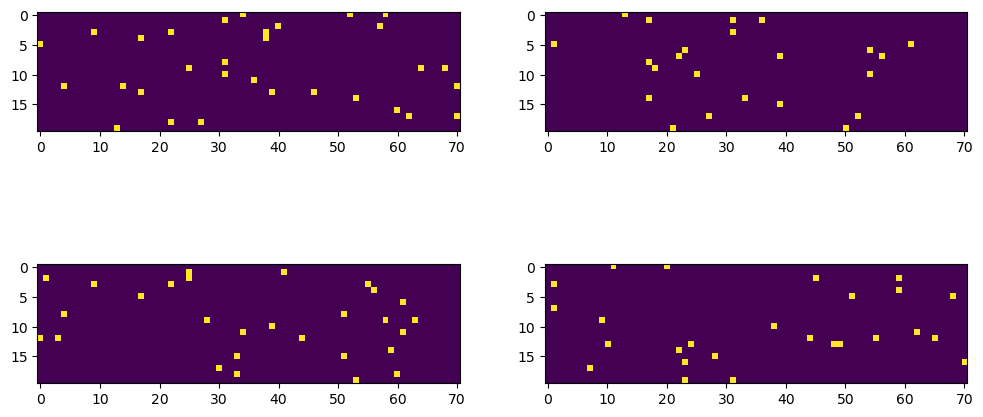

In [42]:
if disp_figs:
    fig,ax = plt.subplot_mosaic('AB;CD',figsize=(12,6))
    ax['A'].imshow(K_dense[...,0])
    ax['B'].imshow(K_dense[...,1])
    ax['C'].imshow(K_dense[...,2])
    ax['D'].imshow(K_dense[...,3])

In [303]:
K_sparse[1][(K_sparse[0]==0) & (K_sparse[2]==3)]

array([11, 20], dtype=int64)

In [299]:
K_sparse[1]

array([11, 13, 20, 34, 52, 58, 17, 25, 31, 31, 36, 41,  1, 25, 40, 45, 57,
       59,  1,  9,  9, 22, 22, 31, 38, 55, 17, 38, 56, 59,  0,  1, 17, 51,
       61, 68, 23, 54, 61,  1, 22, 39, 56,  4, 17, 31, 51,  9, 18, 25, 28,
       58, 63, 64, 68, 25, 31, 38, 39, 54, 34, 36, 61, 62,  0,  3,  4, 14,
       44, 44, 55, 65, 70, 10, 17, 24, 39, 46, 48, 49, 17, 22, 33, 53, 59,
       28, 33, 39, 51, 23, 60, 70,  7, 27, 30, 52, 62, 70, 22, 27, 33, 60,
       13, 21, 23, 31, 50, 53], dtype=int64)

# Generate the PG occurrences

In [78]:
# I suppose I can also do this in sparse and dense
# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.randint(0,T-1,(M,T))
B_dense[B_dense < pg_fr] = 1
B_dense[B_dense >= pg_fr] = 0
B_sparse = np.where(B_dense)

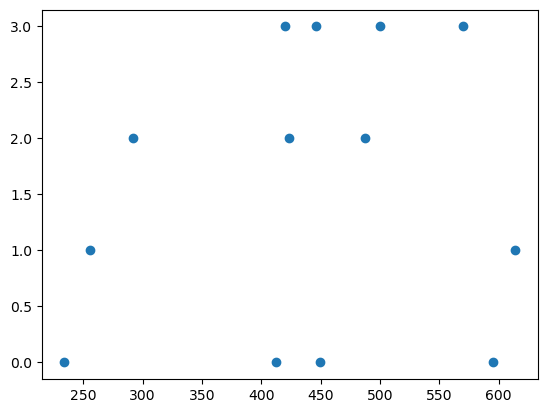

In [79]:
plt.figure()
plt.scatter(B_sparse[1],B_sparse[0])
plt.show()

# Convolve the PG kernels with the PG firing times

In [115]:
# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M)
A_dense = np.zeros((N,T+D,M))
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b]= K_dense[...,b]
    
A_dense.shape
A_dense = A_dense[:,:1000,:]
A_sparse = np.where(A_dense)
A_dense = np.mean(A_dense,axis=2)
A_dense.shape

(20, 1000)

In [119]:
len(A_sparse[0]),len(A_sparse[1]),len(A_sparse[2])

(320, 320, 320)

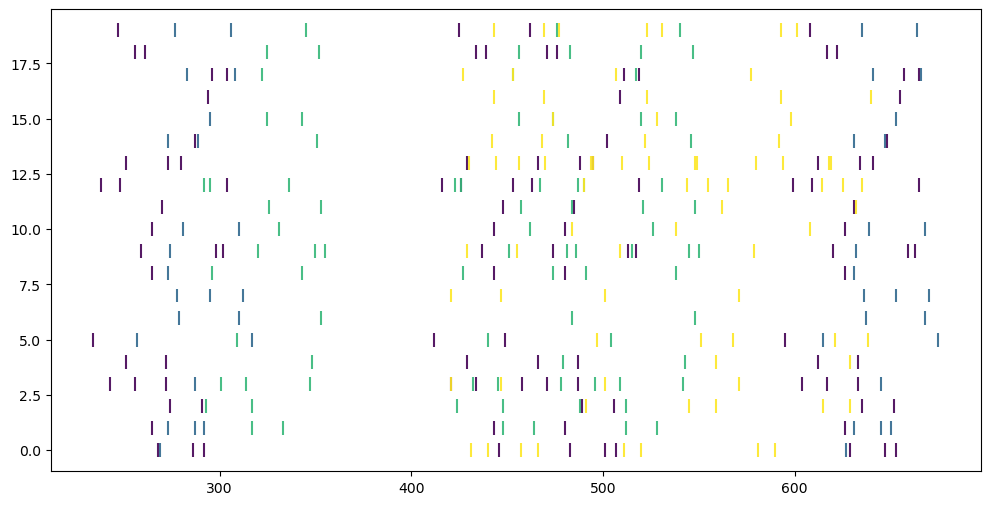

In [337]:

plt.figure(figsize=(12,6))
plt.scatter(A_sparse[1],A_sparse[0],c=A_sparse[2],alpha=0.9,s=100,marker='|')
plt.show()

# Feature extraction!!!

In [187]:
# fr are the Firing Rates is an (N) vector of firing rates for each neuron a
# isis are the interspike interval for each neuron (N x spike_count) matrix
fr = np.sum(A_dense,axis=1)
isis = [A_sparse[1][A_sparse[0]==i] for i in range(N)]

In [188]:
isis[12], A_sparse[1][A_sparse[0]==12]

(array([238, 248, 292, 295, 304, 336, 416, 423, 426, 426, 453, 463, 467,
        487, 490, 490, 519, 531, 544, 555, 565, 599, 609, 614, 625, 635,
        665], dtype=int64),
 array([238, 248, 292, 295, 304, 336, 416, 423, 426, 426, 453, 463, 467,
        487, 490, 490, 519, 531, 544, 555, 565, 599, 609, 614, 625, 635,
        665], dtype=int64))

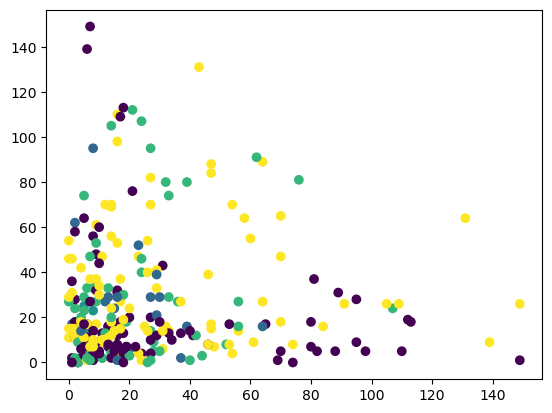

In [192]:
# Feature 1 is the isi between spike i and spike i-1
# Feature 2 is the isi between spike i and spike i+1

feature1 = [np.concatenate(([np.nan],np.diff(k))) for k in isis]
feature2 = [np.concatenate((np.diff(k),[np.nan],)) for k in isis]
if disp_figs:
    plt.figure()
    [plt.scatter(feature1[i],feature2[i],c=A_sparse[2][A_sparse[0]==i]) for i in range(len(feature1))]
    plt.plot()

# calculating all possible isis of a single neuron

In [272]:
isis[0]

array([268, 269, 286, 292, 431, 440, 446, 457, 466, 483, 501, 507, 511,
       520, 581, 590, 627, 629, 647, 653], dtype=int64)

In [204]:
def difference_matrix(a):
    x = np.reshape(a, (len(a), 1))
    return x - x.transpose()

In [319]:
x = difference_matrix(isis[0]).astype('float')
x[np.where(x==0)] = np.nan

In [320]:
counts = np.zeros_like(x)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if j<i:
            counts[i][j] = np.count_nonzero(x==x[i][j])
counts

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [3., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [2., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [2., 2., 2., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 1., 2., 1., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [2., 1., 2., 1., 4., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [2., 2., 1., 1., 2., 4., 2., 4., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [3., 1., 2., 1., 1., 1., 3., 4., 3., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 3., 1., 3., 3.

In [323]:
val = x.flatten()[np.argmax(counts)].astype(int)
np.where(x==val)

(array([ 3,  6, 11, 19], dtype=int64), array([ 2,  5, 10, 18], dtype=int64))

In [332]:
x[3]

array([  24.,   23.,    6.,   nan, -139., -148., -154., -165., -174.,
       -191., -209., -215., -219., -228., -289., -298., -335., -337.,
       -355., -361.])

In [308]:
diag = np.zeros((20,20))
for i in range(20):
    for j in range(20):
        if j<i:
            diag[i,j]=1
            

In [309]:
q = q*diag
q.flatten()[np.argmax(v)]

-0.0

# isi's across neuronal address